# Lab12-1
110065508 李丞恩

In [1]:
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import os
import tensorflow as tf
import re
from pprint import pprint
from tqdm.notebook import tqdm
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

2021-11-12 00:40:09.528762: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2021-11-12 00:40:10.366715: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-12 00:40:10.416952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 00:40:10.418213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.852GHz coreCount: 28 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 335.32GiB/s
2021-11-12 00:40:10.418283: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-11-12 00:40:10.425194: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-11-12 00:40:10.425317: I tensorflow/stream_executor/pl

In [3]:
if not os.path.exists("input") : os.mkdir("input")

## 1. Load Dataset 

In [4]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife/sea_lions
oregon_wildlife/deer
oregon_wildlife/raccoon
oregon_wildlife/nutria
oregon_wildlife/red_fox
oregon_wildlife/black_bear
oregon_wildlife/bald_eagle
oregon_wildlife/raven
oregon_wildlife/cougar
oregon_wildlife/virginia_opossum

total img num: 7168


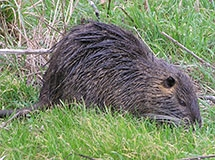

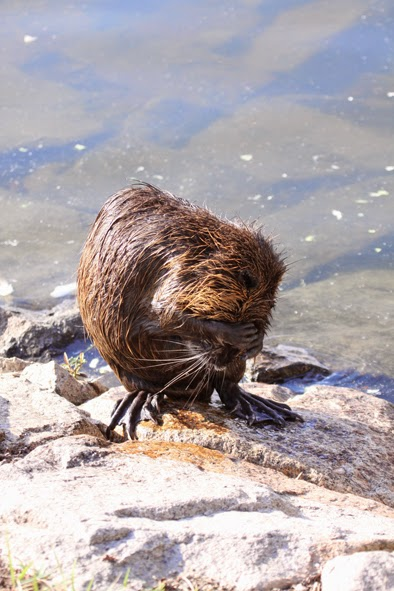

nutria
nutria


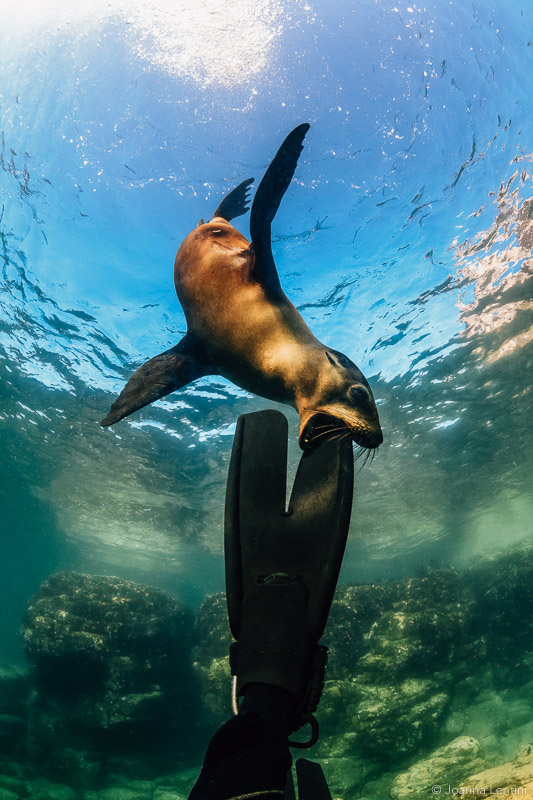

sea_lions


In [5]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

## 2. Prepare the label and filenames

In [6]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [7]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [8]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [2, 1, 5, 1, 8, 5, 3, 8, 3, 8]


In [9]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


## 3. tfrecord preparation

In [10]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

# feel free to modify these Settings.
BUFFER_SIZE = 100
BATCH_SIZE = 4

### 3.1 write the dataset above to tfrecord

這部份的code參考了我在工研院的work。

In [11]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value): # Not used this time
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [12]:
def to_tfrecord(img, label):  
    # print(class_num)
    feature={
        "image": _bytes_feature(img),
        "label": _int64_feature(label)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def prepare_tfrecords(dataset_path, y, tfrecord_file):
    with tf.io.TFRecordWriter(tfrecord_file) as out_file:
        index = [i for i in range(len(dataset_path))]
        for i in range(len(dataset_path)):
            # Read the label and images
            img = open(dataset_path[index[i]], 'rb').read()
            label = y[index[i]]
            example = to_tfrecord(img, label) # write to 
            out_file.write(example.SerializeToString())

In [13]:
prepare_tfrecords(img_path_train, label_train, './input/train.tfrecord')

In [14]:
prepare_tfrecords(img_path_val, label_val, './input/val.tfrecord')

### 3.2 preprocess the data

Since some augmentation is not needed in validation set, we need two mapping functions.

In [15]:
def map_train(image,label):
    image = tf.image.resize(image, [IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED, IMAGE_DEPTH])
    image = tf.image.per_image_standardization(image)
    label = tf.one_hot(label,10)
    return image, label

def map_val(image,label):
    image = tf.image.resize(image, [IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED])
    image = tf.image.per_image_standardization(image)
    label = tf.one_hot(label,10)
    return image, label

the parse function helps recover the images from the tfrecords.

In [16]:
# Create a description of the features.
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'label': tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def _parse_function(example_proto):
    # Parse the input `tf.Example` proto using the dictionary above.
    feature_dict = tf.io.parse_single_example(example_proto, feature_description)
    # Thanks teammate 宏昀 for providing the decode_jpeg method.
    img = tf.io.decode_jpeg(feature_dict['image'], channels=IMAGE_DEPTH)
    label = tf.cast(feature_dict['label'], tf.int64)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img, label = map_train(img, label) 
    return img, label


def _parse_function_val(example_proto):
    # Parse the input `tf.Example` proto using the dictionary above.
    feature_dict = tf.io.parse_single_example(example_proto, feature_description)
    img = tf.io.decode_jpeg(feature_dict['image'], channels=IMAGE_DEPTH)
    label = tf.cast(feature_dict['label'], tf.int64)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img, label = map_val(img, label)
    return img, label

### 3.3 read the data

In [17]:
def read_dataset(tfrecord_file, is_train):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(_parse_function) if is_train else dataset.map(_parse_function_val)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.shuffle(BUFFER_SIZE) if is_train else dataset
    return dataset

In [18]:
dataset_train = read_dataset('./input/train.tfrecord', is_train=True)

In [19]:
dataset_val = read_dataset('./input/val.tfrecord', is_train=False)

In [20]:
dataset_train

<ShuffleDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [21]:
dataset_val

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

## 4. CNN model fitting

In [22]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [23]:
wild_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint(filepath='model.hdf5', monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='auto', save_weights_only = True)
callbacks_list = [checkpoint]

In [24]:
history = wild_model.fit(
    dataset_train, 
    validation_data=dataset_val,
    callbacks=callbacks_list,
    epochs=5
)

Epoch 1/5


2021-11-12 00:40:13.781348: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-12 00:40:13.800272: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2592000000 Hz
2021-11-12 00:40:13.893882: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 40145280 exceeds 10% of free system memory.
2021-11-12 00:40:13.994659: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 20160000 exceeds 10% of free system memory.
2021-11-12 00:40:14.023077: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 46426248 exceeds 10% of free system memory.
2021-11-12 00:40:14.311240: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 20620800 exceeds 10% of free system memory.
2021-11-12 00:40:14.397313: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 24883200 exceeds 10% of free system memory.
2021-11-12 00:40:16.823427: 

      7/Unknown - 6s 30ms/step - loss: 26.6143 - accuracy: 0.1429

2021-11-12 00:40:18.832606: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


    105/Unknown - 9s 38ms/step - loss: 18.7123 - accuracy: 0.1500

2021-11-12 00:40:22.612184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    131/Unknown - 10s 36ms/step - loss: 15.7027 - accuracy: 0.1832

2021-11-12 00:40:23.381311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    143/Unknown - 10s 35ms/step - loss: 14.6181 - accuracy: 0.1976

2021-11-12 00:40:23.665625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    205/Unknown - 12s 34ms/step - loss: 10.8865 - accuracy: 0.2537

2021-11-12 00:40:25.664052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


    281/Unknown - 15s 33ms/step - loss: 8.4949 - accuracy: 0.3052

2021-11-12 00:40:27.878768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    375/Unknown - 17s 32ms/step - loss: 6.8652 - accuracy: 0.3413

2021-11-12 00:40:30.631724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    521/Unknown - 22s 32ms/step - loss: 5.4848 - accuracy: 0.3752

2021-11-12 00:40:35.392534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


    545/Unknown - 23s 33ms/step - loss: 5.3225 - accuracy: 0.3817

2021-11-12 00:40:36.500425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


    763/Unknown - 30s 32ms/step - loss: 4.3309 - accuracy: 0.4171

2021-11-12 00:40:43.296797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    786/Unknown - 31s 32ms/step - loss: 4.2663 - accuracy: 0.4173

2021-11-12 00:40:43.935254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


   1252/Unknown - 47s 33ms/step - loss: 3.2796 - accuracy: 0.4764

2021-11-12 00:40:59.854224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


   1334/Unknown - 49s 33ms/step - loss: 3.1503 - accuracy: 0.4873

2021-11-12 00:41:02.377395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


   1433/Unknown - 52s 33ms/step - loss: 3.0489 - accuracy: 0.4932

2021-11-12 00:41:06.710197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: sRGB: gamma value does not match sRGB
2021-11-12 00:41:06.710231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities
2021-11-12 00:41:07.777241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2021-11-12 00:41:08.310068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: sRGB: gamma value does not match sRGB
2021-11-12 00:41:08.310114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities
2021-11-12 00:41:08.720038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2021-11-12 00:41:10.704818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-12 00:41:11.289579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


1434/1434 [==============================] - 58s 37ms/step - loss: 3.0487 - accuracy: 0.4928 - val_loss: 0.6673 - val_accuracy: 0.7762

Epoch 00001: val_accuracy improved from -inf to 0.77615, saving model to model.hdf5
Epoch 2/5
 105/1434 [=>............................] - ETA: 50s - loss: 1.6307 - accuracy: 0.6190

2021-11-12 00:41:19.070624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 133/1434 [=>............................] - ETA: 47s - loss: 1.7255 - accuracy: 0.5959

2021-11-12 00:41:19.804078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 143/1434 [=>............................] - ETA: 45s - loss: 1.6632 - accuracy: 0.6049

2021-11-12 00:41:20.088403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 205/1434 [===>..........................] - ETA: 42s - loss: 1.6046 - accuracy: 0.6220

2021-11-12 00:41:22.093854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 279/1434 [====>.........................] - ETA: 38s - loss: 1.5382 - accuracy: 0.6237

2021-11-12 00:41:24.302151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 375/1434 [======>.......................] - ETA: 33s - loss: 1.4420 - accuracy: 0.6367

2021-11-12 00:41:27.048874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 521/1434 [=========>....................] - ETA: 29s - loss: 1.4021 - accuracy: 0.6392

2021-11-12 00:41:31.813126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 545/1434 [==========>...................] - ETA: 29s - loss: 1.3901 - accuracy: 0.6404

2021-11-12 00:41:32.908365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


 763/1434 [==============>...............] - ETA: 21s - loss: 1.4392 - accuracy: 0.6255

2021-11-12 00:41:39.712034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 786/1434 [===============>..............] - ETA: 20s - loss: 1.4321 - accuracy: 0.6263

2021-11-12 00:41:40.355009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1253/1434 [=========================>....] - ETA: 5s - loss: 1.3282 - accuracy: 0.6455

2021-11-12 00:41:56.192458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1334/1434 [==========================>...] - ETA: 3s - loss: 1.3130 - accuracy: 0.6492

2021-11-12 00:41:58.710155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1433/1434 [============================>.] - ETA: 0s - loss: 1.3141 - accuracy: 0.6494

2021-11-12 00:42:02.505024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: sRGB: gamma value does not match sRGB
2021-11-12 00:42:02.505060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities
2021-11-12 00:42:03.569091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2021-11-12 00:42:04.101983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: sRGB: gamma value does not match sRGB
2021-11-12 00:42:04.102032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities
2021-11-12 00:42:04.510734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2021-11-12 00:42:06.493190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-12 00:42:07.068449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


1434/1434 [==============================] - 55s 36ms/step - loss: 1.3138 - accuracy: 0.6495 - val_loss: 0.4895 - val_accuracy: 0.8633

Epoch 00002: val_accuracy improved from 0.77615 to 0.86332, saving model to model.hdf5
Epoch 3/5
 105/1434 [=>............................] - ETA: 49s - loss: 1.3637 - accuracy: 0.6643

2021-11-12 00:42:14.964304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 131/1434 [=>............................] - ETA: 46s - loss: 1.3521 - accuracy: 0.6622

2021-11-12 00:42:15.728496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 143/1434 [=>............................] - ETA: 45s - loss: 1.3276 - accuracy: 0.6713

2021-11-12 00:42:16.015587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 205/1434 [===>..........................] - ETA: 41s - loss: 1.2035 - accuracy: 0.7012

2021-11-12 00:42:18.021109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 281/1434 [====>.........................] - ETA: 37s - loss: 1.2690 - accuracy: 0.6806

2021-11-12 00:42:20.231113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 375/1434 [======>.......................] - ETA: 33s - loss: 1.3265 - accuracy: 0.6773

2021-11-12 00:42:22.977991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 521/1434 [=========>....................] - ETA: 29s - loss: 1.3271 - accuracy: 0.6756

2021-11-12 00:42:27.781189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 545/1434 [==========>...................] - ETA: 28s - loss: 1.3211 - accuracy: 0.6766

2021-11-12 00:42:28.879555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


 763/1434 [==============>...............] - ETA: 21s - loss: 1.3134 - accuracy: 0.6750

2021-11-12 00:42:35.749063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 786/1434 [===============>..............] - ETA: 20s - loss: 1.3073 - accuracy: 0.6743

2021-11-12 00:42:36.395178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1253/1434 [=========================>....] - ETA: 5s - loss: 1.2186 - accuracy: 0.6927

2021-11-12 00:42:52.365187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1334/1434 [==========================>...] - ETA: 3s - loss: 1.2171 - accuracy: 0.6919

2021-11-12 00:42:54.892162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1433/1434 [============================>.] - ETA: 0s - loss: 1.2076 - accuracy: 0.6951

2021-11-12 00:42:58.662506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: sRGB: gamma value does not match sRGB
2021-11-12 00:42:58.662542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities
2021-11-12 00:42:59.730577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2021-11-12 00:43:00.261679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: sRGB: gamma value does not match sRGB
2021-11-12 00:43:00.261713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities
2021-11-12 00:43:00.671393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2021-11-12 00:43:02.637301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-12 00:43:03.153290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


1434/1434 [==============================] - 55s 36ms/step - loss: 1.2070 - accuracy: 0.6953 - val_loss: 0.5112 - val_accuracy: 0.8612

Epoch 00003: val_accuracy did not improve from 0.86332
Epoch 4/5
 105/1434 [=>............................] - ETA: 50s - loss: 1.0680 - accuracy: 0.7310

2021-11-12 00:43:10.274541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 131/1434 [=>............................] - ETA: 47s - loss: 1.1731 - accuracy: 0.7099

2021-11-12 00:43:11.021357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 143/1434 [=>............................] - ETA: 45s - loss: 1.1273 - accuracy: 0.7220

2021-11-12 00:43:11.305932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 205/1434 [===>..........................] - ETA: 42s - loss: 1.0866 - accuracy: 0.7220

2021-11-12 00:43:13.295885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 279/1434 [====>.........................] - ETA: 38s - loss: 1.1499 - accuracy: 0.7177

2021-11-12 00:43:15.504757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 375/1434 [======>.......................] - ETA: 33s - loss: 1.1427 - accuracy: 0.7227

2021-11-12 00:43:18.244602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 521/1434 [=========>....................] - ETA: 29s - loss: 1.0752 - accuracy: 0.7332

2021-11-12 00:43:23.014532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 545/1434 [==========>...................] - ETA: 29s - loss: 1.0709 - accuracy: 0.7358

2021-11-12 00:43:24.114170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


 763/1434 [==============>...............] - ETA: 21s - loss: 1.0757 - accuracy: 0.7369

2021-11-12 00:43:30.937455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 786/1434 [===============>..............] - ETA: 20s - loss: 1.0579 - accuracy: 0.7401

2021-11-12 00:43:31.582858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1253/1434 [=========================>....] - ETA: 5s - loss: 1.0567 - accuracy: 0.7438

2021-11-12 00:43:47.447342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1332/1434 [==========================>...] - ETA: 3s - loss: 1.0629 - accuracy: 0.7419

2021-11-12 00:43:49.961315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1433/1434 [============================>.] - ETA: 0s - loss: 1.0645 - accuracy: 0.7415

2021-11-12 00:43:53.747466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: sRGB: gamma value does not match sRGB
2021-11-12 00:43:53.747501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities
2021-11-12 00:43:54.818028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2021-11-12 00:43:55.354952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: sRGB: gamma value does not match sRGB
2021-11-12 00:43:55.354997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities
2021-11-12 00:43:55.764359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2021-11-12 00:43:57.735173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-12 00:43:58.316525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


1434/1434 [==============================] - 55s 36ms/step - loss: 1.0646 - accuracy: 0.7415 - val_loss: 0.4852 - val_accuracy: 0.8570

Epoch 00004: val_accuracy did not improve from 0.86332
Epoch 5/5
 105/1434 [=>............................] - ETA: 49s - loss: 0.9471 - accuracy: 0.7524

2021-11-12 00:44:05.224251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 131/1434 [=>............................] - ETA: 46s - loss: 0.9586 - accuracy: 0.7462

2021-11-12 00:44:05.962026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 143/1434 [=>............................] - ETA: 44s - loss: 0.9266 - accuracy: 0.7517

2021-11-12 00:44:06.246090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 205/1434 [===>..........................] - ETA: 41s - loss: 0.9236 - accuracy: 0.7585

2021-11-12 00:44:08.236983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 281/1434 [====>.........................] - ETA: 37s - loss: 0.9791 - accuracy: 0.7527

2021-11-12 00:44:10.432752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 375/1434 [======>.......................] - ETA: 33s - loss: 0.9585 - accuracy: 0.7580

2021-11-12 00:44:13.165500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 521/1434 [=========>....................] - ETA: 29s - loss: 0.9635 - accuracy: 0.7620

2021-11-12 00:44:17.893405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 545/1434 [==========>...................] - ETA: 28s - loss: 0.9738 - accuracy: 0.7596

2021-11-12 00:44:18.978333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


 763/1434 [==============>...............] - ETA: 21s - loss: 0.9474 - accuracy: 0.7683

2021-11-12 00:44:25.814134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 786/1434 [===============>..............] - ETA: 20s - loss: 0.9353 - accuracy: 0.7700

2021-11-12 00:44:26.467175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1253/1434 [=========================>....] - ETA: 5s - loss: 1.0053 - accuracy: 0.7584

2021-11-12 00:44:42.318135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1334/1434 [==========================>...] - ETA: 3s - loss: 1.0117 - accuracy: 0.7590

2021-11-12 00:44:44.861780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1433/1434 [============================>.] - ETA: 0s - loss: 1.0082 - accuracy: 0.7607

2021-11-12 00:44:48.603890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: sRGB: gamma value does not match sRGB
2021-11-12 00:44:48.603923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities
2021-11-12 00:44:49.670607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2021-11-12 00:44:50.204766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: sRGB: gamma value does not match sRGB
2021-11-12 00:44:50.204802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities
2021-11-12 00:44:50.614721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2021-11-12 00:44:52.597426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-12 00:44:53.091295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


1434/1434 [==============================] - 55s 36ms/step - loss: 1.0082 - accuracy: 0.7606 - val_loss: 0.5267 - val_accuracy: 0.8619

Epoch 00005: val_accuracy did not improve from 0.86332
